Research Question / Hypothesis
----
Can my workouts help predict my vo2Max, and in turn help me live a healthier life?


In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.base            import BaseEstimator
from sklearn.impute          import SimpleImputer
from sklearn.compose         import ColumnTransformer
from sklearn.metrics         import mean_squared_error, mean_absolute_error
from sklearn.ensemble        import ExtraTreesRegressor, RandomForestRegressor
from sklearn.pipeline        import Pipeline
from sklearn.preprocessing   import StandardScaler
from sklearn.neural_network  import MLPRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.linear_model    import RidgeCV, LogisticRegression, LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor

%matplotlib inline
class DummyEstimator(BaseEstimator):
    "Pass through class, methods are present but do nothing."
    def fit(self): pass
    def score(self): pass

# Load data
Note some missing values, will address in pipeline

In [18]:
df = pd.read_csv('ap_health_data.csv')
df.isna().sum()

duration              1
totalDistance         1
totalEnergyBurned     1
vo2max                0
hr_min                0
hr_max                0
hr_q50                0
hr_q90                0
hr_q95                0
hr_q99                0
whr_min              54
whr_max              54
rhr_min              51
rhr_max              51
hrv_min              13
hrv_max              13
hrv_q50              13
hrv_q90              13
hrv_q95              13
hrv_q99              13
dtype: int64

## Target value is `vo2max`
V̇O2 max is widely used as an indicator of cardiorespiratory fitness. In 2016, the American Heart Association published a scientific statement recommending that cardiorespiratory fitness (CRF), quantifiable as V̇O2 max, be regularly assessed and used as a clinical vital sign. This statement was based on mounting evidence that lower fitness levels are associated with high risk of cardiovascular disease, all-cause mortality, and mortality rates stemming from various types of cancers. From [en.wikipedia.org](https://en.wikipedia.org/wiki/VO2_max)

In [15]:
X = df.drop('vo2max', axis = 1)
y = df.vo2max

## Split into Train, Validation, and Test sets
* The training data is used to fit models
* The validation data is used to compare fit models
* The test data is used to evaluate final model

In [30]:
X_training, X_test, y_training, y_test= train_test_split(X, y, test_size=0.15)
X_train, X_valid, y_train, y_valid = train_test_split(X_training, y_training, test_size=0.20)
print('data splits',len(X_train),len(X_valid),len(X_test))

data splits 259 65 58


## First Pass RandomSearchCV
`sklearn` provides a nice function to search a space with `RandomizedSearchCV`
* Here I use it to search through a number of models
* It allows me to narrow in on the ExtraTreesRegressor() for the next step

In [38]:
#stack the list so I can comment out features to compare their effect on the model
feature_columns = [
    'duration',
    'totalDistance',
    'totalEnergyBurned',
    'hr_min',
    'hr_max',
    'hr_q50',
    'hr_q90',
    'hr_q95',
    'hr_q99',
    'whr_min',
    'whr_max',
    'rhr_min',
    'rhr_max',
    'hrv_min',
    'hrv_max',
    'hrv_q50',
    'hrv_q90',
    'hrv_q95',
    'hrv_q99'
    ]

con_pipe = Pipeline([('scaler', StandardScaler()),
                      ('imputer', SimpleImputer(strategy='median', add_indicator=True))])

preprocessing = ColumnTransformer([('continuous',  con_pipe, feature_columns)])

pipe = Pipeline([   ('preprocessing', preprocessing),
                    ('reg', DummyEstimator())]) # Placeholder Estimator

search_space = [{'reg': [MLPRegressor(solver = 'lbfgs', max_iter = 10000)],
                 'reg__alpha': [1.e-01, 1.e-02, 1.e-03],
                 'reg__hidden_layer_sizes': [(50,50), (50,50,50), (100,100)]}, # Actual Estimator

                {'reg': [Lasso()],
                 'reg__alpha': [1.e-01, 1.e-02, 1.e-03]},
                {'reg': [ElasticNet()],
                 'reg__alpha': [1.e-01, 1.e-02, 1.e-03]},
                {'reg': [Ridge()],
                 'reg__alpha': [1.e-01, 1.e-02, 1.e-03]},

                {'reg': [RandomForestRegressor()],
                 'reg__n_estimators': [10, 500],
                 'reg__min_samples_leaf': [2,15]},
                 
                {'reg': [ExtraTreesRegressor()],
                 'reg__n_estimators': [100, 500],
                 'reg__min_samples_leaf': [5,15]}]

# random search
reg_algos_rand = RandomizedSearchCV(estimator=pipe, 
                                    param_distributions=search_space, 
                                    cv=5, 
                                    n_jobs=-1,
                                    verbose=0)
#  Fit grid search
best_model = reg_algos_rand.fit(X_train,y_train)

best_model.best_estimator_.get_params()['reg']

ExtraTreesRegressor(min_samples_leaf=5, n_estimators=500)

### Visualize it
* I like to look at both the MSE and the MAE to not penalize outliers too much
* I also really prefer to plot the predictions to flag anything obvious (like predicting just the mean)
* I like MAE also because it is measured in original target units of measure

Mean squared error: 1.79
Mean absolute error: 1.04


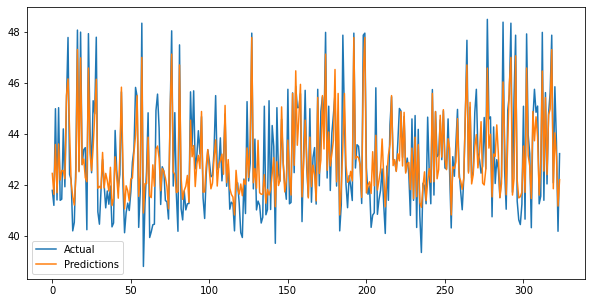

In [41]:
model = Pipeline([   ('preprocessing', preprocessing),
                    ('reg', ExtraTreesRegressor(min_samples_leaf=5, n_estimators=500))]) 
model.fit(X_train, y_train)
y_pred = model.predict(X_training)
y_hat = model.predict(X_valid)
mse = mean_squared_error(y_valid, y_hat)
print(f"Mean squared error: {mse:,.2f}")
mae = mean_absolute_error(y_valid, y_hat)
print(f"Mean absolute error: {mae:,.2f}")

fig, ax = plt.subplots(figsize = (10,5))

ax.plot(y_training.to_numpy(), label = 'Actual')
ax.plot(y_pred, label = 'Predictions')
ax.legend()
plt.show()

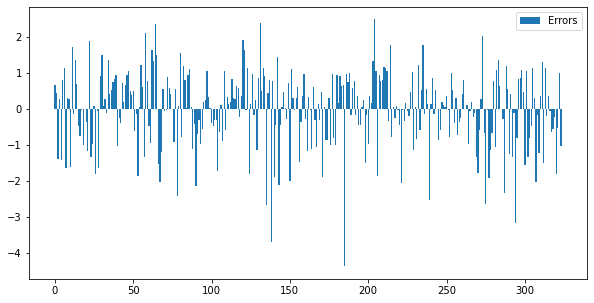

In [50]:
# Error bars a slightly easier to see.  Everything looks pretty normal.
fig, ax = plt.subplots(figsize = (10,5))
ax.bar(list(range(0,len(y_pred))),y_pred - y_training.to_numpy(), label = 'Errors')
ax.legend()
plt.show()

## Final Pass Grid Search 
* Now that I've narrowed down the search space to a single model, I want to tune hyperparameters for the `ExtraTreesRegressor()`
* Using GridSearchCV allows me to check all possible combinations
* I'm happy to use the final model of 

In [61]:
grid_search_space = [{'reg': [ExtraTreesRegressor()],
                 'reg__n_estimators': [100, 250, 500, 1000],
                 'reg__min_samples_leaf': [5,15],
                 'reg__max_depth' : [5,10,15,20, 100],
                 'reg__bootstrap' : [True, False]}]

# random search
reg_algos_rand = GridSearchCV(estimator=pipe, 
                                    param_grid=grid_search_space, 
                                    cv=5, 
                                    n_jobs=-1,
                                    verbose=0)
#  Fit grid search
best_model = reg_algos_rand.fit(X_train,y_train)

best_model.best_estimator_.get_params()['reg']

ExtraTreesRegressor(max_depth=100, min_samples_leaf=5)

# Final Model Results
* Selected `ExtraTreesRegressor(max_depth=100, min_samples_leaf=5)` as final Model
* Test on full data for best results on test set
* Visualize the entire timeline:
    * Since the data was originally dated, there is a nice progression in time
    * By predicting the model against the entire dataset, I can get a holistic view of performance, errors and bias
    * Check the error bars to make sure it looks as expected


Test Mean squared error: 1.80
Test Mean absolute error: 1.04


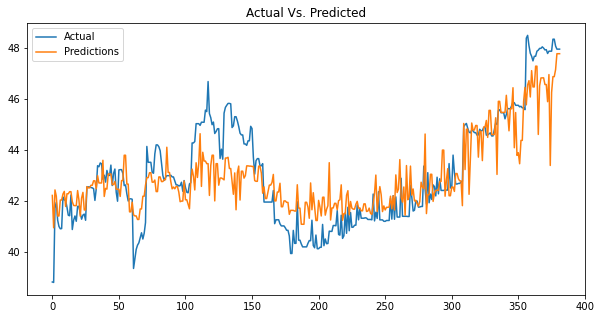

In [87]:
final_model = Pipeline([   ('preprocessing', preprocessing),
                     ('reg', ExtraTreesRegressor(max_depth=100, min_samples_leaf=5))]) 
final_model.fit(X_training, y_training)
y_pred = model.predict(X)
y_hat = model.predict(X_test)
mse = mean_squared_error(y_test, y_hat)
print(f"Test Mean squared error: {mse:,.2f}")
mae = mean_absolute_error(y_test, y_hat)
print(f"Test Mean absolute error: {mae:,.2f}")

fig, ax = plt.subplots(figsize = (10,5))

ax.plot(y.to_numpy(), label = 'Actual')
ax.plot(y_pred, label = 'Predictions')
ax.set_title('Actual Vs. Predicted')
ax.legend()
plt.show()

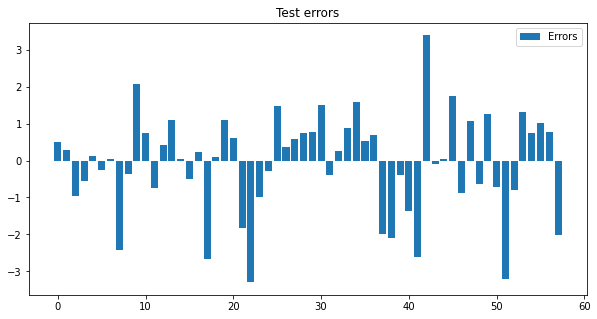

In [78]:
fig, ax = plt.subplots(figsize = (10,5))
ax.bar(list(range(0,len(y_hat))),y_hat - y_test.to_numpy(), label = 'Errors')
ax.legend()
ax.set_title('Test errors')
plt.show()

# Summary
A brief summary of the proceedure is:

1. Load and split data into 3 sets
2. Use RandomizedSearchCV to select a model family
3. Use GridSearchCV to tune hyperparameters of selected model family
4. Fit final model and visualize against actual data

# Findings, Conclusions, and Future Work
**Findings**:
* The measurement of Vo2Max is not a trivial measurment, or a model would have been able to easily fit
    * Thus the measurment my Apple Watch does to approximate my Vo2Max is (probably) not trivial
    * The actual calculation is proprietary, so I'm glad to know that it is not trivial to reverse
    * Which means that there is _actual value in the Apple Watch's Vo2Max calculation_
* My original models wern't the issue
    * I originally only used 'duration', 'totalDistance', and 'totalEnergyBurned'
    * This was not enough for a good prediction, as anything outside of training was pretty bad
    * I wasted a lot of time trying to get the model to do something the data wouldn't allow
    * RandomizedSearchCV is a great tool to get a pretty good impression of the performance the data will allow you to achieve
* I also wasted time playing the lottery
    * By that I mean, I spent too much time doing manual hyperparameter tuning thinking I may hit some magic jackpot of hyperparameter values
    * Of course, I never did, and I only wasted time in the process
    * The short feedback loop of fitting and performance can be addicting, but it is unproductive.
* Looks arn't everything
    * I like to visualize the model so I can catch things that may be obvious on a plot
    * However, complex plots can be hard to accumulate errors visually
    * Thus MSE, and MAE fill that spot of discrete values.
    * I had two prediction plots, one with a flat line vs a quite jagged line that seemed to follow the trend, but unfortunately, the flat line gave a better prediction per MSE and MAE.

**Conclusions**:
* Don't waste time  
    * Know when the models are maxed out, and solve the underlying problem 
* Think about the underlying problems
    * Why isn't your model performing as you wish? Maybe the solution is not to train *longer* but to be *smarter*.
* Therefore, use every tool available
    * MSE is a tool, plotting is a tool, RandomizedSearchCV is a tool
* Don't Give Up
    * I really thought there was nothing to be found in this project, but turns out there was a lot to learn.

**Future Work**
* I originally set out to determine if I could use my workouts to predict my Vo2Max, and help myself understand which actions to take to live a healthier lifestyle.  What I think I've shown to some degree is the validity of the Vo2Max measurment from the Watch.
* With more time and energy, I'd like to look at more exogenous variables to see if somehow steps per day, or stand hours per day, or previous week of workouts contribute significantly to the increase of Vo2Max measure and in turn health.
    